In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives             # 目标函数
from keras.datasets import mnist

### 定义一些常数

In [2]:
epochs = 50
batch_size = 100
original_dim = 784    # 28 * 28
intermediate_dim = 256
latent_dim = 2

### Encoder部分

In [3]:
x = Input(shape = (original_dim,))

h = Dense(intermediate_dim, activation = "relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### Lambda层

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (batch_size, latent_dim), mean = 0.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])

### Decoder部分 

In [5]:
# h_decoded = Dense(intermediate_dim, activation = "relu")(z)
# x_decoded_mean = Dense(original_dim, activation = "sigmoid")(h_decoded)

decoder_h = Dense(intermediate_dim, activation = "relu")
decoder_mean = Dense(original_dim, activation = "sigmoid")
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 损失函数

In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)
    return xent_loss + kl_loss

### 建立模型并编译模型

In [8]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer = "rmsprop", loss = vae_loss)

### 训练模型

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # 60000 * 784
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))     # 10000 * 784

vae.fit(x_train, x_train, 
        shuffle = True,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (x_test, x_test))

vae.save("VariationalAutoEncoder.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 18s 300us/step - loss: 190.3686 - val_loss: 170.9834
Epoch 2/50
60000/60000 [==============================] - 18s 298us/step - loss: 169.2021 - val_loss: 167.9485
Epoch 3/50
60000/60000 [==============================] - 20s 327us/step - loss: 166.6838 - val_loss: 165.8861
Epoch 4/50
60000/60000 [==============================] - 19s 317us/step - loss: 164.7824 - val_loss: 164.0828
Epoch 5/50
60000/60000 [==============================] - 19s 317us/step - loss: 163.1705 - val_loss: 162.9359
Epoch 6/50
60000/60000 [==============================] - 20s 337us/step - loss: 161.8095 - val_loss: 161.4772
Epoch 7/50
60000/60000 [==============================] - 19s 319us/step - loss: 160.7175 - val_loss: 160.3696
Epoch 8/50
60000/60000 [==============================] - 20s 339us/step - loss: 159.7132 - val_loss: 159.5969
Epoch 9/50
60000/60000 [==============================] - 20s 

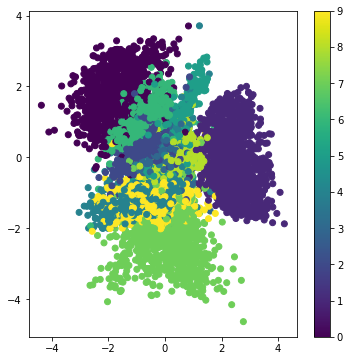

In [11]:
encoder_mean = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

x_test_encoded = encoder_mean.predict(x_test, batch_size = batch_size)
plt.figure(figsize = (6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test)
plt.colorbar()
plt.show()

### 生成器

In [13]:
decoder_input = Input(shape = (latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

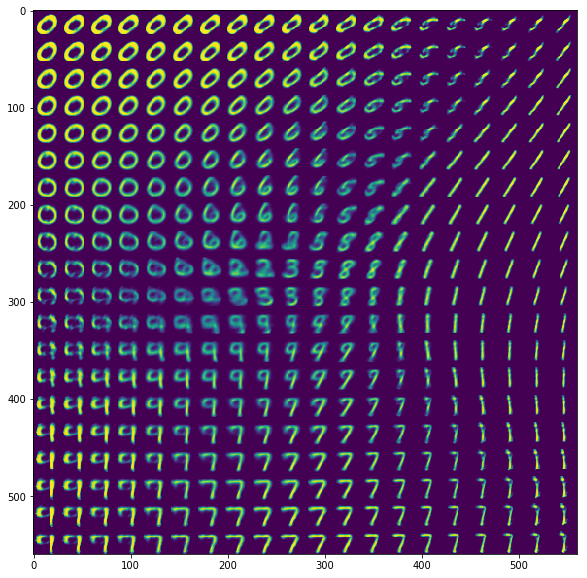

In [16]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[yi, xi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n - i - 1) * digit_size:(n - i) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize = (10, 10))
plt.imshow(figure)
plt.show()